## Imports

In [1]:
import helpers

import torch
from torch import nn
from torch.optim import Adam
from torch.nn.functional import mse_loss

from os.path import join, exists
from os import mkdir

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import plotly
import plotly.express as px

## Data acquisition

In [2]:
DATA_FOLDER = 'datasets/'
BC_NEW_DENSE_FOLDER = join(DATA_FOLDER, 'bc_new_dense')
ZIG_ZAG2_PATH = join(BC_NEW_DENSE_FOLDER, 'zig_zag2.csv')
ANCHORS_PATH = join(BC_NEW_DENSE_FOLDER, 'anchors_bc_atrium_dense.csv')

In [3]:
data_raw = pd.read_csv(ZIG_ZAG2_PATH, index_col='timestamp')
data_raw.head()

device_id  system_id          anchor_id  px  py  pz  \
timestamp                                                                       
1557062000727  14954135790684542069       7586                NaN NaN NaN NaN   
1557062000731  16616973326163504182       7592  dc:8b:28:54:d7:8d NaN NaN NaN   
1557062000741  14954135790684542069       7586                NaN NaN NaN NaN   
1557062000748  16616973326163504182       7592  b8:08:cf:a0:bf:1d NaN NaN NaN   
1557062000748  16616973326163504182       7582              1-250 NaN NaN NaN   

                theta_x   theta_y   theta_z  dx  ...  dist_var  txpower  rssi  \
timestamp                                        ...                            
1557062000727  0.947485  0.055430  1.289884 NaN  ...       NaN      NaN   NaN   
1557062000731       NaN       NaN       NaN NaN  ...  0.178929      NaN -71.0   
1557062000741  0.947991  0.051225  1.293103 NaN  ...       NaN      NaN   NaN   
1557062000748       NaN       NaN       NaN NaN  ...  0.822649      NaN -61.0   
1557062000748       NaN       NaN       NaN NaN  ...       NaN    -77.0 -83.0   

               ble_channel  calib_param_tx  calib_param_n     acc_x     acc_y  \
timestamp                                                                       
1557062000727          NaN             NaN            NaN -0.275427  8.064031   
1557062000731          NaN             NaN            NaN       NaN       NaN   
1557062000741          NaN             NaN            NaN -0.519719  8.078402   
1557062000748          NaN             NaN            NaN       NaN       NaN   
1557062000748          NaN           -77.0            2.0       NaN       NaN   

                  acc_z  is_step_detected  
timestamp                                  
1557062000727  5.166058               0.0  
1557062000731       NaN               NaN  
1557062000741  5.486990               0.0  
1557062000748       NaN               NaN  
1557062000748       NaN               NaN  

[5 rows x 24 columns]

In [4]:
data_anchors = pd.read_csv(ANCHORS_PATH)
data_anchors['anchor_id'] = data_anchors['anchor_id'].str.strip()
data_anchors.set_index("anchor_id", inplace=True)
data_anchors

system_id       px       py      pz  \
anchor_id                                                                   
0x6F2B                                   115200  15.1070  25.2470  1.8120   
0x6F29                                   115200   2.0550  45.6500  1.8780   
0x6F13                                   115200  13.8270   7.9280  1.9050   
0x6F3F                                   115200   1.9350   3.7260  1.9970   
u1uwhdqdy4vx2q0                            7581   0.0000  10.4900  1.6100   
9iaj4ym9u2shxdh                            7581   6.5390   0.9600  1.5550   
xehph6l77u7smwo                            7581   0.0000  18.7080  1.4350   
53saut0wvhrpeyk                            7581  13.8480   7.3670  1.4560   
dc:8b:28:54:da:bc                          7592   0.2250  30.8470  0.9360   
dc:8b:28:54:d8:05                          7592   2.7250   7.3140  5.1600   
dc:8b:28:54:d7:f1                          7592  14.9370  19.0540  0.9450   
dc:8b:28:54:d7:d8                          7592   0.2110  16.0640  0.9150   
dc:8b:28:54:e2:ff                          7592  13.8010   3.7620  0.9170   
dc:8b:28:54:d7:8d                          7592  12.0190  42.9540  0.9220   
b8:08:cf:a0:bf:1d                          7592   6.5600  13.9060  2.5000   
1-250                                      7582  11.8810   7.6830  1.5000   
2-235                                      7582  11.8810  14.8500  1.5000   
2-231                                      7582   2.0690  14.8500  1.5000   
1-249                                      7582   2.0690   7.6830  1.5000   
1-248                                      7582  11.8810   3.7220  1.5000   
17eba1f6-bd0c-2b8b-8559-75e8b171730e       7585   9.6213   6.3959  1.1182   
17eba1fb-bd0c-2b8b-8530-fcfec019262c       7585   9.4597   5.6944  1.2542   

                                      theta_x  theta_y  theta_z  scale_x  \
anchor_id                                                                  
0x6F2B                                    NaN      NaN      NaN      NaN   
0x6F29                                    NaN      NaN      NaN      NaN   
0x6F13                                    NaN      NaN      NaN      NaN   
0x6F3F                                    NaN      NaN      NaN      NaN   
u1uwhdqdy4vx2q0                        1.5708      0.0  1.57080    1.050   
9iaj4ym9u2shxdh                        1.5708      0.0  3.14159    0.575   
xehph6l77u7smwo                        1.5708      0.0  1.57080    0.420   
53saut0wvhrpeyk                        1.5708      0.0 -1.57080    0.350   
dc:8b:28:54:da:bc                         NaN      NaN      NaN      NaN   
dc:8b:28:54:d8:05                         NaN      NaN      NaN      NaN   
dc:8b:28:54:d7:f1                         NaN      NaN      NaN      NaN   
dc:8b:28:54:d7:d8                         NaN      NaN      NaN      NaN   
dc:8b:28:54:e2:ff                         NaN      NaN      NaN      NaN   
dc:8b:28:54:d7:8d                         NaN      NaN      NaN      NaN   
b8:08:cf:a0:bf:1d                         NaN      NaN      NaN      NaN   
1-250                                     NaN      NaN      NaN      NaN   
2-235                                     NaN      NaN      NaN      NaN   
2-231                                     NaN      NaN      NaN      NaN   
1-249                                     NaN      NaN      NaN      NaN   
1-248                                     NaN      NaN      NaN      NaN   
17eba1f6-bd0c-2b8b-8559-75e8b171730e   0.0000      0.0  0.03950      NaN   
17eba1fb-bd0c-2b8b-8530-fcfec019262c   0.0000      0.0  6.20590      NaN   

                                      scale_y  
anchor_id                                      
0x6F2B                                    NaN  
0x6F29                                    NaN  
0x6F13                                    NaN  
0x6F3F                                    NaN  
u1uwhdqdy4vx2q0                          0.63  
9iaj4ym9u2shxdh             

## Data preprocessing

In [5]:
data_raw.index = pd.to_datetime(data_raw.index, unit='ms')

In [6]:
data_raw.system_id.value_counts()

7586      10457
115200     7196
7592       2533
7585       2078
7582        346
7581        269
Name: system_id, dtype: int64

In [7]:
system_id_map = {
    7586: 'imu',
    115200: 'pozyx',
    7581: 'pixlive',
    7592: 'wifi',
    7582: 'bluetooth',
    7585: 'tango'
}

data_raw['system'] = data_raw.system_id.map(system_id_map)

---

#### Tango

In [8]:
data_tango_raw = data_raw.query('system == "tango"').dropna(axis=1, how='all')
data_tango_raw.describe()

device_id  system_id           px           py           pz  \
count  2.078000e+03     2078.0  2078.000000  2078.000000  2078.000000   
mean   1.461461e+19     7585.0     6.437184    13.619203     1.127208   
std    0.000000e+00        0.0     2.956267     7.816743     0.072945   
min    1.461461e+19     7585.0     0.731951     1.390544     0.982195   
25%    1.461461e+19     7585.0     3.637339     7.319391     1.073886   
50%    1.461461e+19     7585.0     6.752330    12.795059     1.115133   
75%    1.461461e+19     7585.0     8.900480    20.337229     1.173874   
max    1.461461e+19     7585.0    12.846235    27.421302     1.349566   

           theta_x      theta_y      theta_z  
count  2078.000000  2078.000000  2078.000000  
mean      0.834956     0.042431     0.330253  
std       0.074515     0.058148     1.926817  
min       0.578549    -0.139157    -3.140998  
25%       0.788392     0.000652    -0.678728  
50%       0.833754     0.037594     0.205870  
75%       0.878361     0.085260     2.152390  
max       1.273950     0.193842     3.140851

In [9]:
plotly.express.line_3d(data_tango_raw, x='px', y='py', z='pz', range_x=[0, 25], range_y=[0, 25], range_z=[0, 25])

In [10]:
data_tango = data_tango_raw.filter(['px', 'py'])
data_tango.head()

px        py
timestamp                                  
2019-05-05 13:13:20.787  9.716898  6.655635
2019-05-05 13:13:20.886  9.708852  6.656457
2019-05-05 13:13:20.992  9.703813  6.652800
2019-05-05 13:13:21.096  9.700219  6.653879
2019-05-05 13:13:21.189  9.697931  6.654535

---

#### IMU

In [11]:
data_imu_raw = data_raw.query('system == "imu"').dropna(axis=1, how='all')
data_imu_raw.describe()

device_id  system_id       theta_x       theta_y       theta_z  \
count  1.045700e+04    10457.0  10457.000000  10457.000000  10457.000000   
mean   1.495414e+19     7586.0      1.067701      0.008812     -0.185292   
std    6.144294e+03        0.0      0.102656      0.040429      1.797424   
min    1.495414e+19     7586.0      0.869686     -0.097188     -3.139780   
25%    1.495414e+19     7586.0      0.996822     -0.021198     -1.960117   
50%    1.495414e+19     7586.0      1.052824      0.009648     -0.048294   
75%    1.495414e+19     7586.0      1.109007      0.037503      1.283548   
max    1.495414e+19     7586.0      1.465773      0.128838      3.140977   

              acc_x         acc_y         acc_z  is_step_detected  
count  10457.000000  10457.000000  10457.000000      10457.000000  
mean      -0.090096      8.741070      4.933565          0.057091  
std        0.721486      1.182036      1.902313          0.232027  
min       -3.324287      5.525311     -1.264570          0.000000  
25%       -0.553250      7.802974      3.609295          0.000000  
50%       -0.112566      8.787327      4.854705          0.000000  
75%        0.354463      9.699829      6.157596          0.000000  
max        3.242856     11.802657     13.143867          1.000000

In [12]:
plotly.express.line_3d(data_imu_raw, x='theta_x', y='theta_y', z='theta_z')

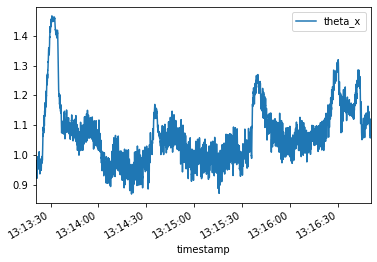

In [13]:
data_imu_raw.plot(y='theta_x')

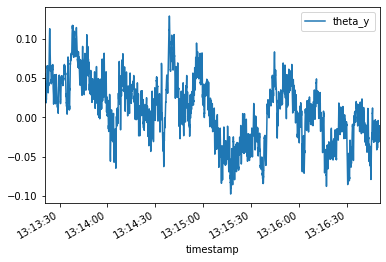

In [14]:
data_imu_raw.plot(y='theta_y')

In [15]:
data_imu = data_imu_raw.filter(['theta_x', 'theta_y', 'acc_x', 'acc_y'])
data_imu.head()

theta_x   theta_y     acc_x     acc_y
timestamp                                                      
2019-05-05 13:13:20.727  0.947485  0.055430 -0.275427  8.064031
2019-05-05 13:13:20.741  0.947991  0.051225 -0.519719  8.078402
2019-05-05 13:13:20.757  0.950169  0.048434 -0.208367  7.965835
2019-05-05 13:13:20.790  0.954798  0.046548 -0.153281  8.111932
2019-05-05 13:13:20.794  0.956288  0.042767 -1.058599  8.317903

---

#### Pozyx

In [16]:
data_pozyx_raw = data_raw.query('system == "pozyx"').dropna(axis=1, how='all')
data_pozyx_raw.describe()

device_id  system_id           px           py      pz     distance  \
count     7196.0     7196.0  7196.000000  7196.000000  7196.0  7196.000000   
mean     28486.0   115200.0     6.736749    13.384426     1.3    17.718330   
std          0.0        0.0     3.225797     8.233523     0.0    10.666586   
min      28486.0   115200.0     0.000000     0.000000     1.3     1.119000   
25%      28486.0   115200.0     4.219750     7.352000     1.3     9.827000   
50%      28486.0   115200.0     6.557000    12.205000     1.3    16.056000   
75%      28486.0   115200.0     9.202750    20.096000     1.3    23.381000   
max      28486.0   115200.0    24.328000    30.862000     1.3    49.380000   

              rssi  
count  7196.000000  
mean    -90.219705  
std       5.688456  
min    -109.000000  
25%     -95.000000  
50%     -90.000000  
75%     -86.000000  
max       0.000000

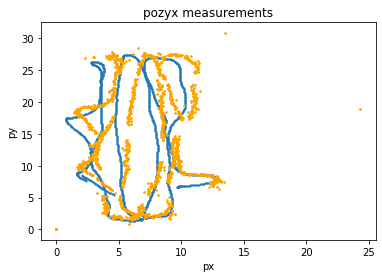

In [17]:
ax = data_tango_raw.plot.scatter('px', 'py', s=1)
data_pozyx_raw.plot.scatter('px', 'py', s=1, c='orange', ax=ax, title='pozyx measurements');

In [18]:
data_tangyx_raw = data_raw[data_raw.system.isin(['tango', 'pozyx'])]
plotly.express.line_3d(data_tangyx_raw, 'px', 'py', 'pz', color='system', range_x=[0, 25], range_y=[0, 30], range_z=[0, 25])

---

#### Pixlive

In [19]:
data_pixlive_raw = data_raw.query('system == "pixlive"').dropna(axis=1, how='all')
data_pixlive_raw.describe()

device_id  system_id          px          py          pz  \
count  2.690000e+02      269.0  269.000000  269.000000  269.000000   
mean   1.495414e+19     7581.0    7.278213    7.272681    1.237018   
std    2.051817e+03        0.0    3.804908    4.773710    0.331732   
min    1.495414e+19     7581.0    1.759124    2.383513    0.301120   
25%    1.495414e+19     7581.0    3.192548    3.188191    0.953081   
50%    1.495414e+19     7581.0    6.205066    7.341159    1.395434   
75%    1.495414e+19     7581.0   12.068423    9.295847    1.459958   
max    1.495414e+19     7581.0   12.201564   18.150848    1.571681   

          theta_x     theta_y     theta_z  
count  269.000000  269.000000  269.000000  
mean    -0.411858    0.019465    1.396284  
std      2.005595    0.038882    0.106836  
min     -3.131576   -0.139456    1.196986  
25%     -1.622128   -0.001317    1.320903  
50%     -1.548381    0.025635    1.366879  
75%      1.390294    0.050459    1.466565  
max      2.802883    0.145246    1.722780

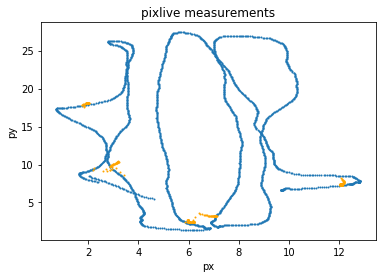

In [20]:
ax = data_tango_raw.plot.scatter('px', 'py', s=1)
data_pixlive_raw.plot.scatter('px', 'py', s=1, c='orange', ax=ax, title='pixlive measurements');

In [21]:
data_tanlive_raw = data_raw[data_raw.system.isin(['tango', 'pixlive'])]
plotly.express.line_3d(data_tanlive_raw, 'px', 'py', 'pz', color='system')

In [22]:
data_pixlive = data_pixlive_raw.filter(['px', 'py'])
data_pixlive.head()

px        py
timestamp                                   
2019-05-05 13:13:31.922  12.095772  7.308615
2019-05-05 13:13:31.954  12.096772  7.307766
2019-05-05 13:13:31.985  12.099903  7.308129
2019-05-05 13:13:32.018  12.100529  7.309312
2019-05-05 13:13:32.055  12.096436  7.307529

---

#### Wifi

In [23]:
data_wifi_raw = data_raw.query('system == "wifi"').dropna(axis=1, how='all')
data_wifi_raw.describe()

device_id  system_id     distance     dist_var         rssi
count  2.533000e+03     2533.0  2533.000000  2533.000000  2533.000000
mean   1.661697e+19     7592.0    20.188377     9.263535   -60.373470
std    2.048404e+03        0.0    10.960980    14.117716     5.585424
min    1.661697e+19     7592.0     2.106000     0.002025   -75.000000
25%    1.661697e+19     7592.0    12.069000     0.576081   -64.000000
50%    1.661697e+19     7592.0    17.481000     2.907025   -61.000000
75%    1.661697e+19     7592.0    26.359000    12.243001   -56.000000
max    1.661697e+19     7592.0    64.387000   151.954929   -40.000000

In [24]:
data_wifi_raw.anchor_id.value_counts()

dc:8b:28:54:da:bc    363
dc:8b:28:54:d7:f1    363
dc:8b:28:54:e2:ff    362
dc:8b:28:54:d7:8d    362
dc:8b:28:54:d7:d8    361
dc:8b:28:54:d8:05    361
b8:08:cf:a0:bf:1d    361
Name: anchor_id, dtype: int64

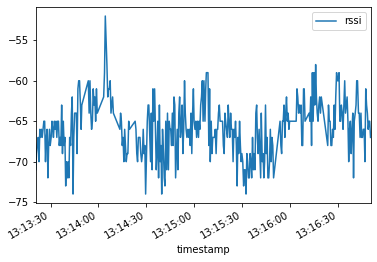

In [25]:
data_wifi_raw.query('anchor_id == "dc:8b:28:54:d7:8d"').plot(y='rssi')

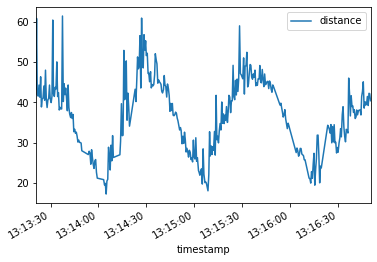

In [26]:
data_wifi_raw.query('anchor_id == "dc:8b:28:54:d7:8d"').plot(y='distance')

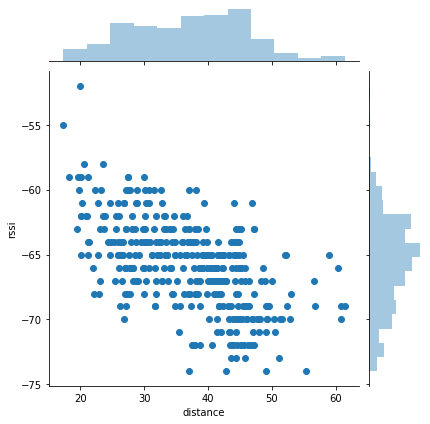

In [27]:
seaborn.jointplot(data=data_wifi_raw.query('anchor_id == "dc:8b:28:54:d7:8d"'), x='distance', y='rssi')

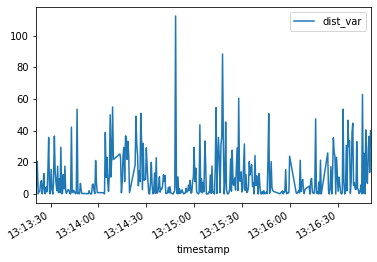

In [28]:
data_wifi_raw.query('anchor_id == "dc:8b:28:54:d7:8d"').plot(y='dist_var')

In [30]:
data_wifi = data_wifi_raw.filter(['anchor_id', 'distance', 'dist_var', 'rssi'])
wifi_anchors = data_wifi['anchor_id'].unique()
data_wifi.head()

anchor_id  distance   dist_var  rssi
timestamp                                                            
2019-05-05 13:13:20.731  dc:8b:28:54:d7:8d    43.299   0.178929 -71.0
2019-05-05 13:13:20.748  b8:08:cf:a0:bf:1d    10.181   0.822649 -61.0
2019-05-05 13:13:20.764  dc:8b:28:54:d8:05    14.283   2.114116 -65.0
2019-05-05 13:13:20.782  dc:8b:28:54:e2:ff     4.973   1.638400 -50.0
2019-05-05 13:13:20.799  dc:8b:28:54:da:bc    31.388  26.183689 -66.0

#### Bluetooth

In [31]:
data_bluetooth_raw = data_raw.query('system == "bluetooth"').dropna(axis=1, how='all')
data_bluetooth_raw.describe()

device_id  system_id    distance     txpower        rssi  \
count  3.460000e+02      346.0  346.000000  346.000000  346.000000   
mean   1.661697e+19     7582.0    3.787039  -76.710983  -86.086705   
std    2.050966e+03        0.0    2.926572    0.704228    6.015294   
min    1.661697e+19     7582.0    0.281838  -77.000000 -101.000000   
25%    1.661697e+19     7582.0    1.778279  -77.000000  -90.000000   
50%    1.661697e+19     7582.0    2.818383  -77.000000  -86.000000   
75%    1.661697e+19     7582.0    5.011872  -77.000000  -82.000000   
max    1.661697e+19     7582.0   19.952623  -75.000000  -66.000000   

       calib_param_tx  calib_param_n  
count      346.000000          346.0  
mean       -76.710983            2.0  
std          0.704228            0.0  
min        -77.000000            2.0  
25%        -77.000000            2.0  
50%        -77.000000            2.0  
75%        -77.000000            2.0  
max        -75.000000            2.0

In [32]:
data_bluetooth_raw.anchor_id.value_counts()

2-231    89
2-235    80
1-248    67
1-250    60
1-249    50
Name: anchor_id, dtype: int64

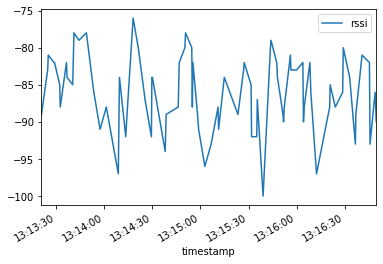

In [33]:
data_bluetooth_raw.query('anchor_id == "2-235"').plot(y='rssi')

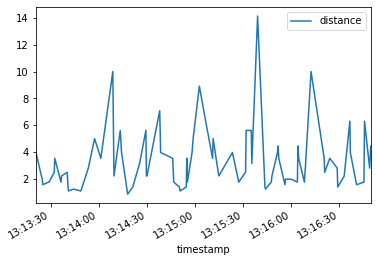

In [34]:
data_bluetooth_raw.query('anchor_id == "2-235"').plot(y='distance')

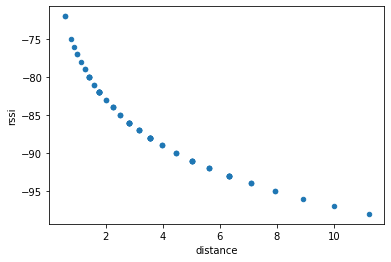

In [35]:
data_bluetooth_raw.query('anchor_id == "2-231"').plot.scatter(x='distance', y='rssi')

In [36]:
data_bluetooth = data_bluetooth_raw.filter(['anchor_id', 'distance'])
bluetooth_anchors = data_bluetooth['anchor_id'].unique()
data_bluetooth.head()

anchor_id  distance
timestamp                                  
2019-05-05 13:13:20.748     1-250  1.995262
2019-05-05 13:13:20.920     2-235  3.981072
2019-05-05 13:13:21.132     2-231  6.309573
2019-05-05 13:13:24.268     2-231  3.548134
2019-05-05 13:13:24.274     1-248  0.562341

## Resampling

In [37]:
data_tango_resampled = data_tango.resample('100 ms', label='right', closed='right').last().interpolate()
data_tango_resampled

px        py
timestamp                                  
2019-05-05 13:13:20.800  9.716898  6.655635
2019-05-05 13:13:20.900  9.708852  6.656457
2019-05-05 13:13:21.000  9.703813  6.652800
2019-05-05 13:13:21.100  9.700219  6.653879
2019-05-05 13:13:21.200  9.697931  6.654535
...                           ...       ...
2019-05-05 13:16:50.100  4.306732  5.713674
2019-05-05 13:16:50.200  4.383184  5.652425
2019-05-05 13:16:50.300  4.453672  5.598052
2019-05-05 13:16:50.400  4.535831  5.540321
2019-05-05 13:16:50.500  4.624880  5.484211

[2098 rows x 2 columns]

In [38]:
data_wifi_resampled = data_wifi.groupby('anchor_id').resample('100 ms', label='right', closed='right').last().drop('anchor_id', axis=1).interpolate()
data_wifi_resampled

distance  dist_var       rssi
anchor_id         timestamp                                              
b8:08:cf:a0:bf:1d 2019-05-05 13:13:20.800  10.181000  0.822649 -61.000000
                  2019-05-05 13:13:20.900  10.265600  0.887527 -60.200000
                  2019-05-05 13:13:21.000  10.350200  0.952406 -59.400000
                  2019-05-05 13:13:21.100  10.434800  1.017284 -58.600000
                  2019-05-05 13:13:21.200  10.519400  1.082163 -57.800000
...                                              ...       ...        ...
dc:8b:28:54:e2:ff 2019-05-05 13:16:50.100  12.014333  2.519627 -52.666667
                  2019-05-05 13:16:50.200  11.681000  2.000942 -53.000000
                  2019-05-05 13:16:50.300  11.347667  1.482258 -53.333333
                  2019-05-05 13:16:50.400  11.014333  0.963573 -53.666667
                  2019-05-05 13:16:50.500  10.681000  0.444889 -54.000000

[14676 rows x 3 columns]

In [39]:
data_bluetooth_resampled = data_bluetooth.groupby('anchor_id').resample('100 ms', label='right', closed='right').last().drop('anchor_id', axis=1).interpolate()
data_bluetooth_resampled

distance
anchor_id timestamp                        
1-248     2019-05-05 13:13:24.300  0.562341
          2019-05-05 13:13:24.400  0.617160
          2019-05-05 13:13:24.500  0.671978
          2019-05-05 13:13:24.600  0.726796
          2019-05-05 13:13:24.700  0.781614
...                                     ...
2-235     2019-05-05 13:16:49.300  3.524863
          2019-05-05 13:16:49.400  3.760356
          2019-05-05 13:16:49.500  3.995849
          2019-05-05 13:16:49.600  4.231343
          2019-05-05 13:16:49.700  4.466836

[10365 rows x 1 columns]

In [40]:
test = data_bluetooth_resampled.merge(data_tango_resampled, left_index=True, right_index=True)

Shape before resampling:  (362, 4)
Shape after resampling:  (2097, 3)


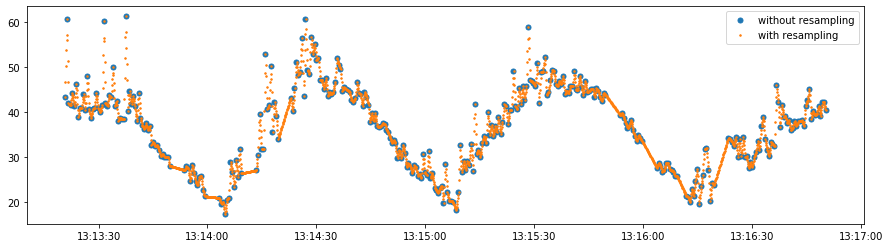

In [41]:
plt.figure(figsize=(15,4))
one_anchor_before = data_wifi.query('anchor_id == "dc:8b:28:54:d7:8d"')
one_anchor_after = data_wifi_resampled.loc['dc:8b:28:54:d7:8d']
print('Shape before resampling: ', one_anchor_before.shape)
print('Shape after resampling: ', one_anchor_after.shape)
ax = plt.plot(one_anchor_before['distance'], '.', markersize=10);
plt.plot(one_anchor_after['distance'], '.', markersize=3);
plt.legend(['without resampling', 'with resampling']);

Shape before resampling:  (60, 2)
Shape after resampling:  (2089, 1)


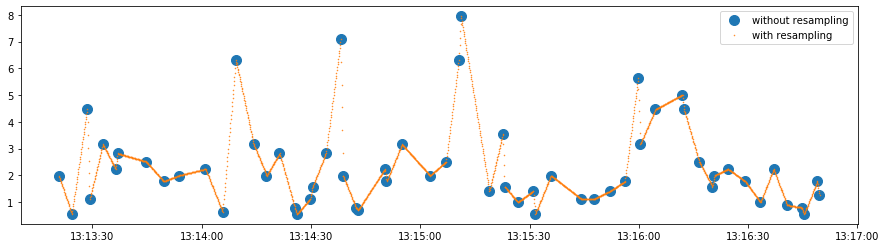

In [42]:
plt.figure(figsize=(15,4))
one_anchor_before = data_bluetooth.query('anchor_id == "1-250"')
one_anchor_after = data_bluetooth_resampled.loc['1-250']
print('Shape before resampling: ', one_anchor_before.shape)
print('Shape after resampling: ', one_anchor_after.shape)
ax = plt.plot(one_anchor_before['distance'], '.', markersize=20);
plt.plot(one_anchor_after['distance'], '.', markersize=1);
plt.legend(['without resampling', 'with resampling']);

In [43]:
data_anchors.query('system_id == "7592"').index

Index(['dc:8b:28:54:da:bc', 'dc:8b:28:54:d8:05', 'dc:8b:28:54:d7:f1',
       'dc:8b:28:54:d7:d8', 'dc:8b:28:54:e2:ff', 'dc:8b:28:54:d7:8d',
       'b8:08:cf:a0:bf:1d'],
      dtype='object', name='anchor_id')

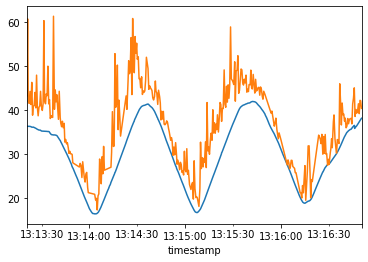

In [97]:
anchor_id = 'dc:8b:28:54:d7:8d'
anchor_info = data_anchors.loc[anchor_id]
anchor_px = anchor_info['px']
anchor_py = anchor_info['py']
real_distance = ((data_tango_resampled['px'] - anchor_px) ** 2 + (data_tango_resampled['py'] - anchor_py) ** 2).apply(lambda x: np.sqrt(x))
ax = real_distance.plot();
distance_anchor = data_wifi_resampled.loc[anchor_id].distance
distance_anchor.plot(ax=ax)

In [100]:
real_distance.shape

(2098,)

In [102]:
distance_anchor.shape

(2097,)

(15.117487267581964, 43.333049746597645, 14.077767337105701, 63.64013434909678)

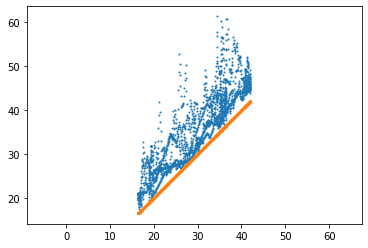

In [103]:
plt.scatter(real_distance[:-1], distance_anchor, s=1)
plt.scatter(real_distance, real_distance, s=1)
plt.axis('equal')

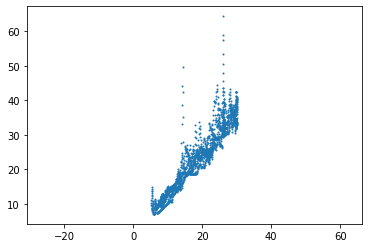

In [45]:
anchor_id = 'dc:8b:28:54:da:bc'
anchor_info = data_anchors.loc[anchor_id]
anchor_px = anchor_info['px']
anchor_py = anchor_info['py']
real_distance = ((data_tango_resampled['px'] - anchor_px) ** 2 + (data_tango_resampled['py'] - anchor_py) ** 2).apply(lambda x: np.sqrt(x))

distance_anchor = data_wifi_resampled.loc[anchor_id].distance
plt.scatter(real_distance, distance_anchor, s=1)
plt.axis('equal');

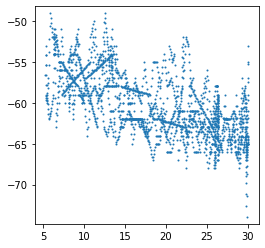

In [46]:
anchor_id = 'dc:8b:28:54:da:bc'
anchor_info = data_anchors.loc[anchor_id]
anchor_px = anchor_info['px']
anchor_py = anchor_info['py']
real_distance = ((data_tango_resampled['px'] - anchor_px) ** 2 + (data_tango_resampled['py'] - anchor_py) ** 2).apply(lambda x: np.sqrt(x))

rssi_anchor = data_wifi_resampled.loc[anchor_id].rssi
plt.figure(figsize=(4,4))
plt.scatter(real_distance, rssi_anchor, s=1)
plt.axis('equal');

In [47]:
data_anchors.query('system_id == "7582"').index

Index(['1-250', '2-235', '2-231', '1-249', '1-248'], dtype='object', name='anchor_id')

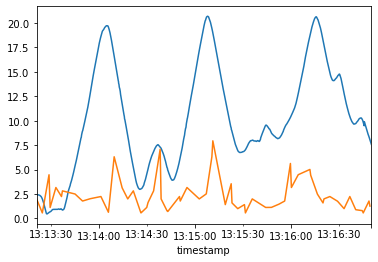

In [48]:
anchor_id = '1-250'
anchor_info = data_anchors.loc[anchor_id]
anchor_px = anchor_info['px']
anchor_py = anchor_info['py']
real_distance = ((data_tango_resampled['px'] - anchor_px) ** 2 + (data_tango_resampled['py'] - anchor_py) ** 2).apply(lambda x: np.sqrt(x))
ax = real_distance.plot();
distance_anchor = data_bluetooth_resampled.loc[anchor_id].distance
distance_anchor.plot(ax=ax)

In [49]:
data_imu_resampled = data_imu.resample('100 ms', label='right', closed='right').mean()
data_imu_resampled

theta_x   theta_y     acc_x      acc_y
timestamp                                                       
2019-05-05 13:13:20.800  0.951346  0.048881 -0.443079   8.107621
2019-05-05 13:13:20.900  0.954384  0.035871 -0.202140   7.815428
2019-05-05 13:13:21.000  0.950873  0.038285 -0.390388   8.417536
2019-05-05 13:13:21.100  0.962915  0.043833 -0.610730   8.353829
2019-05-05 13:13:21.200  0.960162  0.036777 -0.053648   7.954339
...                           ...       ...       ...        ...
2019-05-05 13:16:50.100  1.110040 -0.028524 -0.169567   7.920330
2019-05-05 13:16:50.200  1.115315 -0.027636 -0.060833   8.051098
2019-05-05 13:16:50.300  1.086910 -0.013506 -0.117356   9.726654
2019-05-05 13:16:50.400  1.075588 -0.012436  0.249082  10.475337
2019-05-05 13:16:50.500  1.079000 -0.013811 -0.271835  10.072255

[2098 rows x 4 columns]

In [50]:
resampled_timestamps = data_tango_resampled.index
data = pd.DataFrame(index=resampled_timestamps)
features_columns = []


data = data.merge(data_tango_resampled, left_index=True, right_index=True)
data = data.merge(data_imu_resampled, left_index=True, right_index=True)

for anchor_id in wifi_anchors:
    renamed = data_wifi_resampled.loc[anchor_id].rename({'distance': f'{anchor_id}_distance', 'dist_var': f'{anchor_id}_dist_var', 'rssi': f'{anchor_id}_rssi'}, axis=1)
    features_columns += renamed.columns.to_list()
    data = data.merge(renamed, left_index=True, right_index=True)

for anchor_id in bluetooth_anchors:
    renamed = data_bluetooth_resampled.loc[anchor_id].rename({'distance': f'{anchor_id}distance', 'rssi': f'{anchor_id}_rssi'}, axis=1)
    data = data.merge(renamed, left_index=True, right_index=True)

resampled_timestamps = data.index

In [51]:
features_target = data_tango_resampled.columns.to_list()

In [52]:
data_input = data[features_columns]
data_input

dc:8b:28:54:d7:8d_distance  \
timestamp                                             
2019-05-05 13:13:24.800                     40.9300   
2019-05-05 13:13:24.900                     40.9495   
2019-05-05 13:13:25.000                     40.9690   
2019-05-05 13:13:25.100                     40.9885   
2019-05-05 13:13:25.200                     41.0080   
...                                             ...   
2019-05-05 13:16:49.000                     39.2460   
2019-05-05 13:16:49.100                     39.8498   
2019-05-05 13:16:49.200                     40.4536   
2019-05-05 13:16:49.300                     41.0574   
2019-05-05 13:16:49.400                     41.6612   

                         dc:8b:28:54:d7:8d_dist_var  dc:8b:28:54:d7:8d_rssi  \
timestamp                                                                     
2019-05-05 13:13:24.800                    0.193600              -67.000000   
2019-05-05 13:13:24.900                    0.834013              -66.833333   
2019-05-05 13:13:25.000                    1.474427              -66.666667   
2019-05-05 13:13:25.100                    2.114840              -66.500000   
2019-05-05 13:13:25.200                    2.755254              -66.333333   
...                                             ...                     ...   
2019-05-05 13:16:49.000                   28.037025              -66.000000   
2019-05-05 13:16:49.100                   29.721109              -65.800000   
2019-05-05 13:16:49.200                   31.405193              -65.600000   
2019-05-05 13:16:49.300                   33.089276              -65.400000   
2019-05-05 13:16:49.400                   34.773360              -65.200000   

                         b8:08:cf:a0:bf:1d_distance  \
timestamp                                             
2019-05-05 13:13:24.800                     10.0346   
2019-05-05 13:13:24.900                      9.9480   
2019-05-05 13:13:25.000                     10.2812   
2019-05-05 13:13:25.100                     10.6144   
2019-05-05 13:13:25.200                     10.9476   
...                                             ...   
2019-05-05 13:16:49.000                     10.3740   
2019-05-05 13:16:49.100                     10.2958   
2019-05-05 13:16:49.200                     10.2176   
2019-05-05 13:16:49.300                     10.1394   
2019-05-05 13:16:49.400                     10.0612   

                         b8:08:cf:a0:bf:1d_dist_var  b8:08:cf:a0:bf:1d_rssi  \
timestamp                                                                     
2019-05-05 13:13:24.800                    1.122971                   -55.8   
2019-05-05 13:13:24.900                    1.340964                   -56.0   
2019-05-05 13:13:25.000                    1.174160                   -56.4   
2019-05-05 13:13:25.100                    1.007356                   -56.8   
2019-05-05 13:13:25.200                    0.840552                   -57.2   
...                                             ...                     ...   
2019-05-05 13:16:49.000                    0.145161                   -58.0   
2019-05-05 13:16:49.100                    0.359010                   -56.8   
2019-05-05 13:16:49.200                    0.572858                   -55.6   
2019-05-05 13:16:49.300                    0.786707                   -54.4   
2019-05-05 13:16:49.400                    1.000555                   -53.2   

                         dc:8b:28:54:d8:05_distance  \
timestamp                                             
2019-05-05 13:13:24.800                      19.235   
2019-05-05 13:13:24.900                      21.046   
2019-05-05 13:13:25.000                      20.155   
2019-05-05 13:13:25.100                      19.264   
2019-05-05 13:13:25.200                      18.373   
...                                             ...   
2019-05-05 13:16:49.000                      56.398   
2019-05-05 13:16:49.100                   

In [53]:
data_target = data[features_target]
data_target

px        py
timestamp                                   
2019-05-05 13:13:24.800  10.311290  6.803739
2019-05-05 13:13:24.900  10.358226  6.809969
2019-05-05 13:13:25.000  10.408030  6.818697
2019-05-05 13:13:25.100  10.458849  6.830470
2019-05-05 13:13:25.200  10.523026  6.850173
...                            ...       ...
2019-05-05 13:16:49.000   3.604047  6.491786
2019-05-05 13:16:49.100   3.658778  6.420919
2019-05-05 13:16:49.200   3.721145  6.343967
2019-05-05 13:16:49.300   3.789488  6.265271
2019-05-05 13:16:49.400   3.857231  6.189751

[2047 rows x 2 columns]

## Autoencoder

In [54]:
n_samples, dim_features = data_input.shape
_, dim_target = data_target.shape

In [55]:
input = torch.from_numpy(data_input.values).float()
target = torch.from_numpy(data_target.values).float()
theta_target = torch.from_numpy(data[['theta_x', 'theta_y']].values).float()

In [56]:
N_EPOCHS = 5000
BATCH_SIZE = 200

### helpers

In [57]:
def train_encoder(model, input, target, nb_epochs, batch_size, loss_function=nn.MSELoss()):
    """Train an autoencoder"""
    
    optimizer = Adam(model.parameters())
    losses = []
    n_batches = (input.size(0) - 1) // batch_size + 1
    
    encoder, decoder = model

    for _ in range(nb_epochs):
        batch_losses = []
        for b in range(n_batches):
            batch_input = input[b * batch_size: (b + 1) * batch_size]
            batch_target = target[b * batch_size: (b + 1) * batch_size]
            encoded = encoder(batch_input)
            decoded = decoder(encoded)
            
            loss = loss_function(decoded, batch_input)
            
            optimizer.zero_grad() # set gradients to zero
            loss.backward() # compute gradient
            optimizer.step() # update weights
            batch_losses.append(loss.item())
        losses.append(torch.Tensor(batch_losses).mean().item())
        
    return losses

In [58]:
RESULTS_PATH = 'results/'
MODEL_FILE_NAME = 'model.pt'
TRAIN_LOSS_FILE_NAME = 'train_loss.pt'

def save_result(result, results_name):
    if not exists(RESULTS_PATH):
        mkdir(RESULTS_PATH)
        
    
    path = join(RESULTS_PATH, results_name)
    if not exists(path):
        mkdir(path)
        
    torch.save(result['train_loss'], join(path, TRAIN_LOSS_FILE_NAME))
    torch.save(result['model'].state_dict(), join(path, MODEL_FILE_NAME))

def load_result(results_name, model):
    if not exists(RESULTS_PATH):
        raise FileNotFoundError('There is no model directory')
        
    path = join(RESULTS_PATH, results_name)
    if not exists(path):
        raise FileNotFoundError(f'The file {results_name} doesn\'t exist')
        
    train_loss = torch.load(join(path, TRAIN_LOSS_FILE_NAME))
    model_state_dict = torch.load(join(path, MODEL_FILE_NAME))
    
    model.load_state_dict(model_state_dict)

    result = {
        'model': model,
        'train_loss': train_loss
    }

    return result

In [59]:
n_hidden_units = 15

def create_autoencoder_model(dim):
    encoder = nn.Sequential(
        nn.Linear(dim_features, n_hidden_units), nn.ReLU(),
        nn.Linear(n_hidden_units, dim)
    )

    decoder = nn.Sequential(
        nn.Linear(dim, n_hidden_units), nn.ReLU(),
        nn.Linear(n_hidden_units, dim_features)
    )

    model = nn.Sequential(
        encoder,
        decoder
    )
    
    return model

In [60]:
def plot_multiloss_evolution(train_losses):
    assert len(train_losses) <= 6
    colors = seaborn.color_palette('Paired')
    loss_names = []
    
    plt.figure(figsize=(12,6))
    for idx, loss_name in enumerate(train_losses):
        plt.plot(train_losses[loss_name], c=colors[2 * idx + 1])
        loss_names.append('train_' + loss_name)
    
    plt.legend(loss_names)
    plt.ylim(0, 200)
    plt.grid(True);

### Unconstrained model

In [61]:
model = create_autoencoder_model(2)

In [62]:
%%time
losses = train_encoder(model, input, target, 4 * N_EPOCHS, BATCH_SIZE)

result_unconstraint = {
    'model': model,
    'train_loss': losses
}

CPU times: user 5min 54s, sys: 4.57 s, total: 5min 58s
Wall time: 6min 11s


In [144]:
# save model
results_name = 'real_autoencoder_unconstrained'
save_result(result_unconstraint, results_name)

In [218]:
# load model
results_name = 'real_autoencoder_unconstrained'
result_unconstraint = load_result(results_name, model)

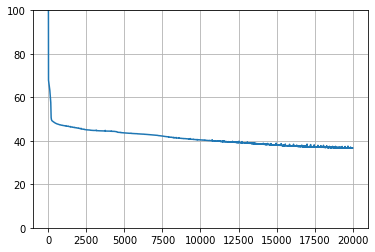

In [63]:
plt.plot(result_unconstraint['train_loss'])
plt.grid()
plt.ylim([0,100]);

In [64]:
encoded = result_unconstraint['model'][0](input)
encoded_pd = pd.DataFrame(encoded.detach().numpy(), columns=['px', 'py'])

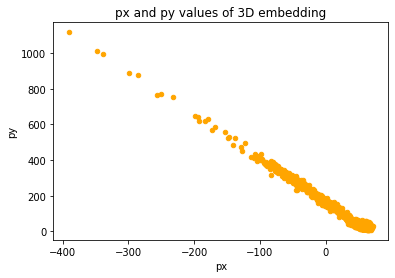

In [65]:
encoded_pd.plot.scatter('px', 'py', c='orange', title='px and py values of 3D embedding');

### Model with constraints

In [66]:
features_difference = data_input.iloc[1:].values - data_input.iloc[:-1].values

In [67]:
norm = np.linalg.norm(features_difference, axis=1)

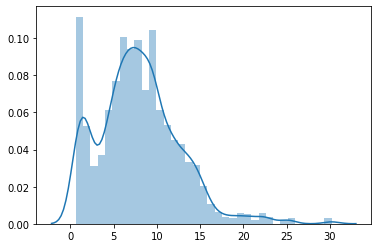

In [68]:
seaborn.distplot(norm)

In [69]:
def recovery_loss(input, decoded, **kwargs):
    return mse_loss(decoded, input)

def fixed_points_loss(target, encoded, **kwargs):
    mask = [0]
    return mse_loss(encoded[mask], target[mask])

MAX_DISTANCE_THRESHOLD = 0.2
def subsequent_distances_loss(encoded, **kwargs):
    subsequent_distances = encoded[:-1].sub(encoded[1:]).pow(2).sum(dim=1)
    mask = subsequent_distances.gt(MAX_DISTANCE_THRESHOLD).float()
    return (subsequent_distances * mask).mean()

def angle_differences_loss(encoded, **kwargs):
    directions = encoded[1:].sub(encoded[:-1])
    angles = torch.atan2(directions[:, 1], directions[:, 0] + 1e-5)
    angle_differences = angles[:-1].sub(angles[1:])
    return angle_differences.pow(2).mean()

def imu_loss(encoded, theta_target, **kwargs):
    theta_pred = encoded[1:] - encoded[:-1]
    return mse_loss(theta_pred, theta_target[1:])

In [70]:
def train_encoder_with_constraints(model, input, target, nb_epochs, batch_size, loss_functions):
    """Train a model with constraints"""
    
    optimizer = Adam(model.parameters())
    
    train_losses = {}
    for loss_function in loss_functions:
        train_losses[loss_function['function'].__name__] = []
    train_losses['total_loss'] = []
    n_batches = (input.size(0) - 1) // batch_size + 1
    
    encoder, decoder = model

    
    for _ in range(nb_epochs):
        losses = {}
        for loss_function in loss_functions:
            losses[loss_function['function'].__name__] = []
        losses['total_loss'] = []
        
        for b in range(n_batches):
            batch_input = input[b * batch_size: (b + 1) * batch_size]
            batch_target = target[b * batch_size: (b + 1) * batch_size]
            encoded = encoder(batch_input)
            decoded = decoder(encoded)
            batch_theta_target = theta_target[b * batch_size: (b + 1) * batch_size]
            
            loss = 0
            for loss_function in loss_functions:
                f_loss = loss_function['weight'] * loss_function['function'](
                    input=batch_input,
                    target=batch_target,
                    encoded=encoded,
                    decoded=decoded,
                    theta_target=batch_theta_target
                )
                loss = loss + f_loss
                losses[loss_function['function'].__name__].append(f_loss.item())
            losses['total_loss'].append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        for loss_function in loss_functions:
            train_losses[loss_function['function'].__name__].append(np.mean(losses[loss_function['function'].__name__]))
        train_losses['total_loss'].append(np.mean(losses['total_loss']))
        
    return train_losses

In [71]:
%%time

model_with_constraints = create_autoencoder_model(dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 10.0
    }, {
        'function': subsequent_distances_loss,
        'weight': 10.0
    }
]

train_losses_with_constraints = train_encoder_with_constraints(model_with_constraints, input, target, 2 * N_EPOCHS, BATCH_SIZE, loss_functions)
result_with_constraints = {
    'model': model_with_constraints,
    'train_loss': train_losses_with_constraints
}

CPU times: user 4min 11s, sys: 2.64 s, total: 4min 13s
Wall time: 4min 19s


In [73]:
# save model
results_name = 'real_autoencoder_constrained'
save_result(result_with_constraints, results_name)

In [74]:
# load model
results_name = 'real_autoencoder_constrained'
result_with_constraints = load_result(results_name, model)

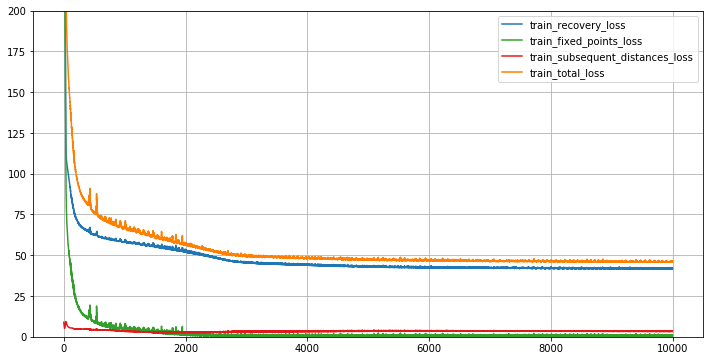

In [75]:
plot_multiloss_evolution(result_with_constraints['train_loss'])

In [76]:
encoded = model_with_constraints[0](input)
encoded_pd = pd.DataFrame(encoded.detach().numpy(), index=resampled_timestamps, columns=['px', 'py'])

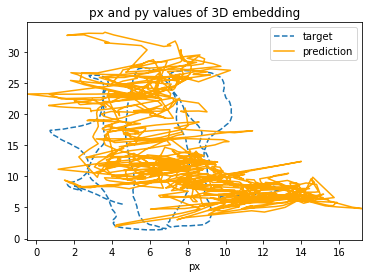

In [77]:
ax = data_tango_resampled.plot.line('px', 'py', linestyle='--')
encoded_pd.plot.line('px', 'py', c='orange', title='px and py values of 3D embedding', ax=ax);
ax.legend(['target', 'prediction']);

---

In [78]:
%%time

model_with_constraints = create_autoencoder_model(dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': imu_loss,
        'weight': 10.0
    }
]

train_losses_with_constraints = train_encoder_with_constraints(model_with_constraints, input, target, 2 * N_EPOCHS, BATCH_SIZE, loss_functions)
result_with_constraints = {
    'model': model_with_constraints,
    'train_loss': train_losses_with_constraints
}

CPU times: user 3min 31s, sys: 2.53 s, total: 3min 33s
Wall time: 3min 39s


In [79]:
# save model
results_name = 'real_autoencoder_constrained2'
save_result(result_with_constraints, results_name)

In [80]:
# load model
results_name = 'real_autoencoder_constrained2'
result_with_constraints = load_result(results_name, model)

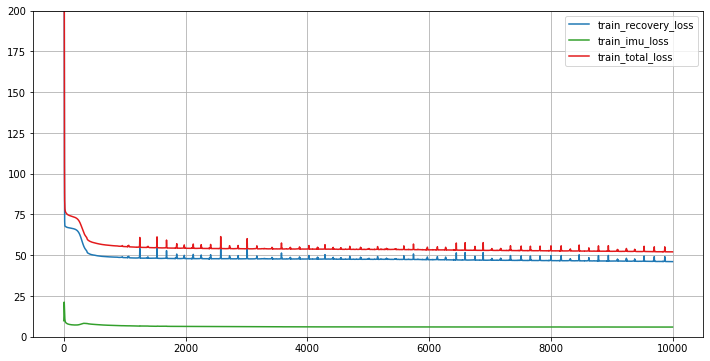

In [81]:
plot_multiloss_evolution(result_with_constraints['train_loss'])

In [82]:
encoded = model_with_constraints[0](input)
encoded_pd = pd.DataFrame(encoded.detach().numpy(), index=resampled_timestamps, columns=['px', 'py'])

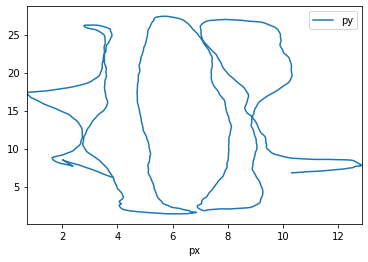

In [83]:
data_target.plot('px', 'py')

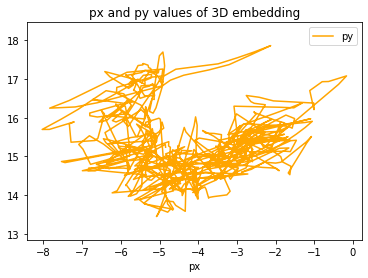

In [84]:
encoded_pd.plot.line('px', 'py', c='orange', title='px and py values of 3D embedding');
ax.legend(['target', 'prediction']);
plt.axis('equal');

---

In [85]:
%%time

loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': imu_loss,
        'weight': 10.0
    }, {
        'function': fixed_points_loss,
        'weight': 10.0
    }
]

train_losses_with_constraints = train_encoder_with_constraints(model_with_constraints, input, target, 2 * N_EPOCHS, BATCH_SIZE, loss_functions)
result_with_constraints = {
    'model': model_with_constraints,
    'train_loss': train_losses_with_constraints
}

CPU times: user 3min 55s, sys: 2.46 s, total: 3min 57s
Wall time: 4min 4s


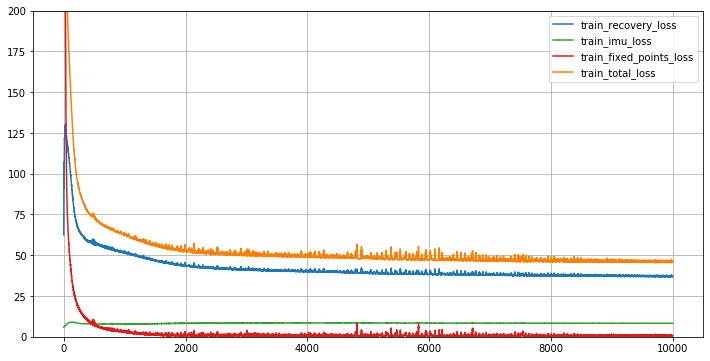

In [86]:
plot_multiloss_evolution(result_with_constraints['train_loss'])

In [87]:
encoded = model_with_constraints[0](input)
encoded_pd = pd.DataFrame(encoded.detach().numpy(), index=resampled_timestamps, columns=['px', 'py'])

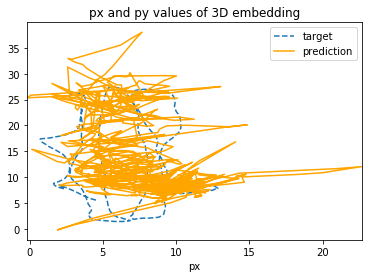

In [88]:
ax = data_tango_resampled.plot.line('px', 'py', linestyle='--')
encoded_pd.plot.line('px', 'py', c='orange', title='px and py values of 3D embedding', ax=ax);
ax.legend(['target', 'prediction']);

---

---

# ---------------

In [181]:
model = create_autoencoder_model(2)

In [182]:
%%time
losses = train_encoder(model, input, target, 4 * N_EPOCHS, BATCH_SIZE)

result_unconstraint = {
    'model': model,
    'train_loss': losses
}

CPU times: user 4min 53s, sys: 4.04 s, total: 4min 57s
Wall time: 5min


In [183]:
# save model
results_name = 'real_autoencoder_unconstrained'
save_result(result_unconstraint, results_name)

In [184]:
# load model
results_name = 'real_autoencoder_unconstrained'
result_unconstraint = load_result(results_name, model)

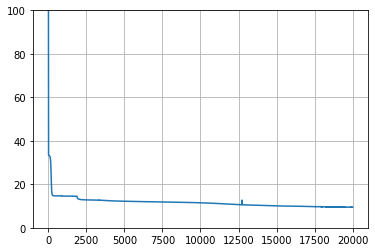

In [185]:
plt.plot(result_unconstraint['train_loss'])
plt.grid()
plt.ylim([0,100]);

In [186]:
encoded = result_unconstraint['model'][0](input)
encoded_pd = pd.DataFrame(encoded.detach().numpy(), columns=['px', 'py'])

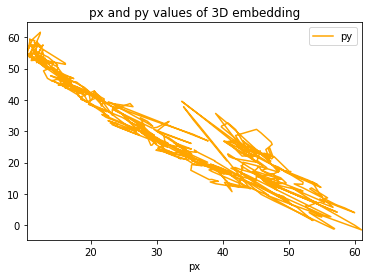

In [187]:
encoded_pd.plot.line('px', 'py', c='orange', title='px and py values of 3D embedding');

In [188]:
%%time

model_with_constraints = create_autoencoder_model(dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 10.0
    }, {
        'function': subsequent_distances_loss,
        'weight': 10.0
    }
]

train_losses_with_constraints = train_encoder_with_constraints(model_with_constraints, input, target, 2 * N_EPOCHS, BATCH_SIZE, loss_functions)
result_with_constraints = {
    'model': model_with_constraints,
    'train_loss': train_losses_with_constraints
}

CPU times: user 3min 33s, sys: 2.53 s, total: 3min 35s
Wall time: 3min 38s


In [189]:
# save model
results_name = 'real_autoencoder_constrained'
save_result(result_with_constraints, results_name)

In [190]:
# load model
results_name = 'real_autoencoder_constrained'
result_with_constraints = load_result(results_name, model)

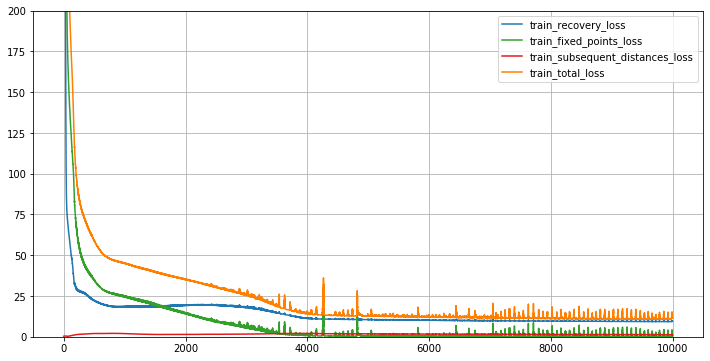

In [191]:
plot_multiloss_evolution(result_with_constraints['train_loss'])

In [192]:
encoded = model_with_constraints[0](input)
encoded_pd = pd.DataFrame(encoded.detach().numpy(), index=resampled_timestamps, columns=['px', 'py'])

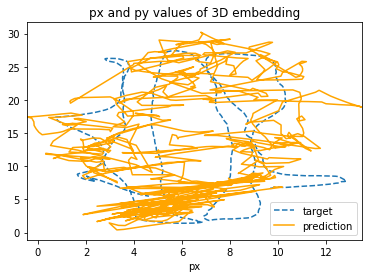

In [193]:
ax = data_tango_resampled.plot.line('px', 'py', linestyle='--')
encoded_pd.plot.line('px', 'py', c='orange', title='px and py values of 3D embedding', ax=ax);
ax.legend(['target', 'prediction']);

---

In [194]:
%%time

model_with_constraints = create_autoencoder_model(dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': imu_loss,
        'weight': 10.0
    }
]

train_losses_with_constraints = train_encoder_with_constraints(model_with_constraints, input, target, 2 * N_EPOCHS, BATCH_SIZE, loss_functions)
result_with_constraints = {
    'model': model_with_constraints,
    'train_loss': train_losses_with_constraints
}

CPU times: user 3min 3s, sys: 2.33 s, total: 3min 5s
Wall time: 3min 8s


In [195]:
# save model
results_name = 'real_autoencoder_constrained2'
save_result(result_with_constraints, results_name)

In [196]:
# load model
results_name = 'real_autoencoder_constrained2'
result_with_constraints = load_result(results_name, model)

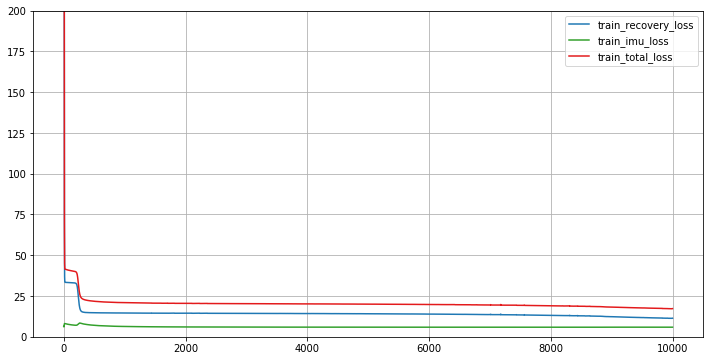

In [197]:
plot_multiloss_evolution(result_with_constraints['train_loss'])

In [198]:
encoded = model_with_constraints[0](input)
encoded_pd = pd.DataFrame(encoded.detach().numpy(), index=resampled_timestamps, columns=['px', 'py'])

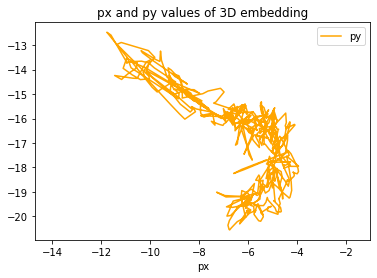

In [200]:
encoded_pd.plot.line('px', 'py', c='orange', title='px and py values of 3D embedding');
ax.legend(['target', 'prediction']);
plt.axis('equal');

---

In [201]:
%%time

loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': imu_loss,
        'weight': 10.0
    }, {
        'function': fixed_points_loss,
        'weight': 10.0
    }
]

train_losses_with_constraints = train_encoder_with_constraints(model_with_constraints, input, target, 2 * N_EPOCHS, BATCH_SIZE, loss_functions)
result_with_constraints = {
    'model': model_with_constraints,
    'train_loss': train_losses_with_constraints
}

CPU times: user 3min 21s, sys: 2.4 s, total: 3min 23s
Wall time: 3min 26s


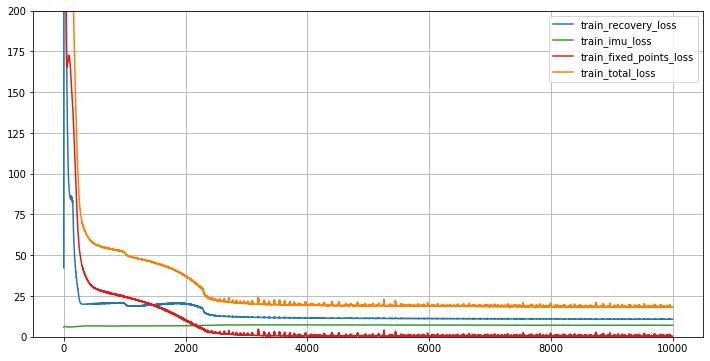

In [202]:
plot_multiloss_evolution(result_with_constraints['train_loss'])

In [203]:
encoded = model_with_constraints[0](input)
encoded_pd = pd.DataFrame(encoded.detach().numpy(), index=resampled_timestamps, columns=['px', 'py'])

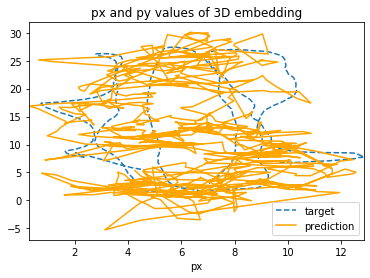

In [204]:
ax = data_tango_resampled.plot.line('px', 'py', linestyle='--')
encoded_pd.plot.line('px', 'py', c='orange', title='px and py values of 3D embedding', ax=ax);
ax.legend(['target', 'prediction']);